##Data Read

In [1]:
from google.colab import drive # mounts drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive
%cd MyDrive
%cd GitHub
%cd CRONOS_Fao56_adjustment


/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/GitHub
/content/drive/MyDrive/GitHub/CRONOS_Fao56_adjustment


In [3]:
import pandas as pd

df = pd.read_csv('OK004.txt') #imports pandas and the data for OK004

In [4]:
from datetime import datetime # imports the funcitions important for dealing with timeseries data

## Dataframe Setup

In [5]:
date_strings = df.TIMESTAMP # collects timestamps
date_series = pd.to_datetime(date_strings,format = '%Y-%m-%d %H:%M:%S') #reads in their series format
days = date_series.dt.strftime('%Y -%j') #creates a list in the fao specified format
df['DOY'] = date_series.dt.strftime('%Y%j')# adds a column to the df inorder to group by the day and year of the rows

In [6]:
pip install pyfao56 # imports fuctions related to fao 56 (Thorp, 2017) https://github.com/kthorp/pyfao56/tree/main

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.4 MB/s eta 0:00:00


In [7]:
start_date = datetime(2021,10,8)
end_date = datetime(2021,10,10)
print(start_date)
print(end_date)# sets start and end dates for the window in question (if I could get the CRONOS data to properly Group)

2021-10-08 00:00:00
2021-10-10 00:00:00


In [8]:
df.index = days #sets the days format as the index for the CRONOS df

In [9]:
del df['TIMESTAMP']
del df['station']
del df['farm']
del df['field']
del df['latitude']
del df['longitude']
del df['NDVI_Avg']# deleting non numeric or issue prone fields

In [10]:
ranged_data = df.loc[str(start_date):str(end_date)] #selects the data frame of the specified time frame

In [11]:
ranged_data[:].fillna('Unknown', inplace=True) #supposed to remove nans in the index

In [12]:
mean_df = ranged_data.groupby('DOY')
print(mean_df) #this is where the CRONOS data kind of breaks down and doesnt let me do anything with it

In [13]:
for col in ranged_data.columns:
    print(col) #prints column names for viewing

RECORD
altitude
battery_voltage_Min
PTemp_Avg
counts_1_Tot
counts_2_Tot
solar_flux_density_Avg
lightning_strike_count_Tot
precipitation_Tot
strike_distance_Min
wind_speed_Avg
wind_direction_Avg
wind_speed_gust_Max
air_temperature_Avg
vapor_pressure_Avg
barometric_pressure_Avg
relative_humidity_Avg
humidity_sensor_temperature_Avg
tilt_north_south_Avg
tilt_west_east_Avg
DOY


In [14]:
import pyfao56 as fao #imports foa 56 model

In [15]:
par = fao.Parameters()#Table 17 located on page 163 of fao56 pdf

par.Kcbini = 0.15 #params here and below are for winter wheat table 17
par.Kcbmid = 1.10
par.Kcbend = 0.15

par.Lini = 160 # Table 11 (pg130)
par.Ldev = 75
par.Lmid = 75
par.Lend = 25

par.hini = 0.01
par.hmax = 1.0

par.thetaFC= 0.5665 # data determined by field soil analysis
par.thetaWP= 0.1423
par.theta0= 0.25

par.Zrini= 0.1 # (table 22 pg189)
par.Zrmax= 1.6
par.pbase= 0.55

par.Ze= 0.25 # soil data params (Table 19 pg)
par.REW = 9
par.CN2 = 66
par.savefile('ArnallParams.par')

In [16]:
par = fao.Parameters()
par.loadfile('ArnallParams.par')
print(par)#loads the generated param file

************************************************************************
pyfao56: FAO-56 Evapotranspiration in Python
Parameter Data
Timestamp: 05/08/2024 09:19:51
************************************************************************
Comments:
************************************************************************
   0.1500 Kcbini, Kcb Initial (FAO-56 Table 17)
   1.1000 Kcbmid, Kcb Mid (FAO-56 Table 17)
   0.1500 Kcbend, Kcb End (FAO-56 Table 17)
      160 Lini, Length Stage Initial (days) (FAO-56 Table 11)
       75 Ldev, Length Stage Development (days) (FAO-56 Table 11)
       75 Lmid, Length Stage Mid (days) (FAO-56 Table 11)
       25 Lend, Length Stage End (days) (FAO-56 Table 11)
   0.0100 hini, Plant Height Initial (m)
   1.0000 hmax, Plant Height Maximum (m) (FAO-56 Table 12)
   0.5665 thetaFC, Vol. Soil Water Content, Field Capacity (cm3/cm3)
   0.1423 thetaWP, Vol. Soil Water Content, Wilting Point (cm3/cm3)
   0.2500 theta0, Vol. Soil Water Content, Initial (cm3/cm3)
  

In [ ]:
"""
wth = fao.Weather()
wth.comment = str(' Data for the OK004 site from ' + str(start_date) + ' to ' + str(end_date))
wth.site = 'OK004'
wth.z = 338.9
wth.lat = 35.0526
wth.rfcrp = 'S'
wth.wndht = 2.0

wth.savefile('ArnallWeather.wth')
"""
#I originally had planned to use this to generated the weather param file one column at a time but that did not work and after ~10 hours spent working the problem I decided to hard write the file
#after ~3 more hours not getting that to work I used one of the authors weather files, with the arnall params, as a proof of concept that the idea is feasable

In [17]:
wth = fao.Weather()
wth.loadfile('weather example.wth') # loading that example file

In [18]:
irr = fao.Irrigation()
irr.addevent(2013, 177, 0, 0)# proof of how to add irrigation events

In [19]:
mdl = fao.Model('2013-001','2013-365', par, wth, irr=irr)
mdl.run()
print(mdl) #models and prints daily data over the

/usr/local/lib/python3.10/dist-packages/pyfao56/model.py:797: RuntimeWarning: invalid value encountered in scalar divide
  io.DPe = max([effrain + effirr/io.fw - io.De, 0.0])
/usr/local/lib/python3.10/dist-packages/pyfao56/model.py:800: RuntimeWarning: invalid value encountered in scalar divide
  De = io.De - effrain - effirr/io.fw + io.E/io.few + io.DPe
/usr/local/lib/python3.10/dist-packages/pyfao56/model.py:797: RuntimeWarning: invalid value encountered in scalar divide
  io.DPe = max([effrain + effirr/io.fw - io.De, 0.0])
/usr/local/lib/python3.10/dist-packages/pyfao56/model.py:800: RuntimeWarning: invalid value encountered in scalar divide
  De = io.De - effrain - effirr/io.fw + io.E/io.few + io.DPe
/usr/local/lib/python3.10/dist-packages/pyfao56/model.py:797: RuntimeWarning: invalid value encountered in scalar divide
  io.DPe = max([effrain + effirr/io.fw - io.De, 0.0])
/usr/local/lib/python3.10/dist-packages/pyfao56/model.py:800: RuntimeWarning: invalid value encountered in scal

************************************************************************
pyfao56: FAO-56 Evapotranspiration in Python
Output Data
Timestamp: 05/08/2024 09:19:57
Simulation start date: 01/01/2013
Simulation end date: 12/31/2013
Soil method: D - Default FAO-56 homogenous soil bucket approach
************************************************************************
Comments: 
************************************************************************
Year-DOY  Year  DOY  DOW      Date  ETref  tKcb   Kcb     h Kcmax    fc    fw   few      De    Kr    Ke      E     DPe    Kc    ETc     TAW TAWrmax    TAWb    Zr     p     RAW    Ks Kcadj ETcadj      T      DP    Dinc      Dr     fDr   Drmax  fDrmax      Db     fDb   Irrig IrrLoss    Rain  Runoff  Year  DOY  DOW      Date
2013-001  2013  001  Tue  01/01/13  1.360 0.150 0.150 0.010 1.206 0.000 1.000 1.000 123.588 0.000 0.000  0.000   0.000 0.150  0.204  42.420 -99.999 -99.999 0.100 0.742  31.469 0.983 0.148  0.201  0.201   0.000 -99.999  31.601   

## Model of a different variety
In lieu of not getting anything to work with my original plans I pivoted to trying to develop a model that might be able to predict the stations neutron counts based on realative Humidity and barometric pressure alone


In [20]:
import pandas as pd #in 6 messages Chat GPT did most of this
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# Assuming df is your pandas DataFrame containing the data
# df = pd.read_csv("your_data.csv")

# Selecting features and target variable
X = df[["relative_humidity_Avg", "barometric_pressure_Avg"]]
y = df["counts_1_Tot"]  # Adjust the target variable if needed

# Handling missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# You can also print the coefficients and intercept if needed
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Mean Squared Error: 60967.36989243194
Coefficients: [ 0.34078596 -4.71246373]
Intercept: 5246.487947651813


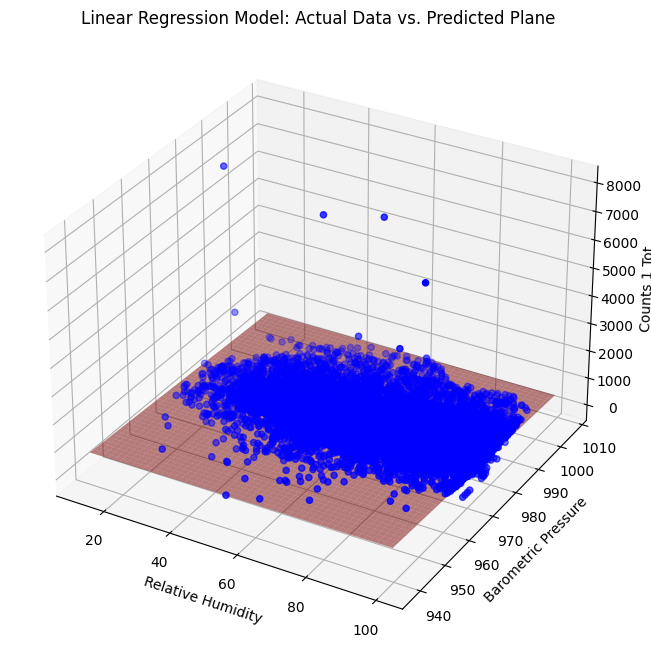

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df = df[["relative_humidity_Avg", "barometric_pressure_Avg", "counts_1_Tot"]]
# Generate meshgrid for plotting the plane
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predictions on the meshgrid
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot actual data points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='blue', label='Actual Data')

# Plot predicted plane
ax.plot_surface(xx, yy, Z, alpha=0.5, color='red', label='Predicted Plane')

ax.set_xlabel('Relative Humidity')
ax.set_ylabel('Barometric Pressure')
ax.set_zlabel('Counts 1 Tot')

plt.title('Linear Regression Model: Actual Data vs. Predicted Plane')
plt.show()



In [22]:
# Convert relevant columns to numeric
df.loc[:, "relative_humidity_Avg"] = pd.to_numeric(df["relative_humidity_Avg"], errors='coerce')
df.loc[:, "barometric_pressure_Avg"] = pd.to_numeric(df["barometric_pressure_Avg"], errors='coerce')
df.loc[:, "counts_1_Tot"] = pd.to_numeric(df["counts_1_Tot"], errors='coerce')
# Calculate the interquartile range (IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_no_outliers = df[(df >= lower_bound) & (df <= upper_bound)].dropna()

# Update X and y with the DataFrame without outliers
X_no_outliers = df_no_outliers[["relative_humidity_Avg", "barometric_pressure_Avg"]]
y_no_outliers = df_no_outliers["counts_1_Tot"]

# Handling missing values and splitting data
imputer_no_outliers = SimpleImputer(strategy='mean')
X_imputed_no_outliers = imputer_no_outliers.fit_transform(X_no_outliers)

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(X_imputed_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

# Creating and training the linear regression model without outliers
model_no_outliers = LinearRegression()
model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

# Making predictions on the test set without outliers
y_pred_no_outliers = model_no_outliers.predict(X_test_no_outliers)

# Evaluating the model without outliers
mse_no_outliers = mean_squared_error(y_test_no_outliers, y_pred_no_outliers)
print("Mean Squared Error (No Outliers):", mse_no_outliers)


Mean Squared Error (No Outliers): 4650.841848679101


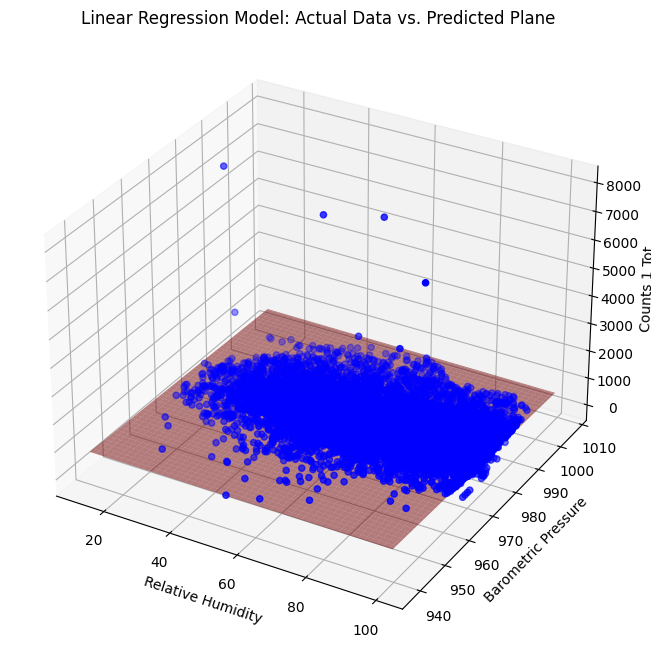

In [34]:
df = df[["relative_humidity_Avg", "barometric_pressure_Avg", "counts_1_Tot"]]
# Generate meshgrid for plotting the plane
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predictions on the meshgrid
Z = model_no_outliers.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot actual data points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='blue', label='Actual Data')

# Plot predicted plane
ax.plot_surface(xx, yy, Z, alpha=0.5, color='red', label='Predicted Plane')

ax.set_xlabel('Relative Humidity')
ax.set_ylabel('Barometric Pressure')
ax.set_zlabel('Counts 1 Tot')

plt.title('Linear Regression Model: Actual Data vs. Predicted Plane')
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test_no_outliers, y_pred_no_outliers)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_no_outliers, y_pred_no_outliers)

# Compute R-squared (R2)
r2 = r2_score(y_test_no_outliers, y_pred_no_outliers)

# Print regression metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)



Mean Squared Error (MSE): 4650.841848679101
Mean Absolute Error (MAE): 54.99842056972518
R-squared (R2): 0.07564602596393266


Frankly, Chat GPT wrote the majoriy of the above code as told by the coding style. It took around an hour of conversation but frankly I probably should have started with GPT in mind. In all we can clearly see that this is not a good model (R2 = 0.08) and realative humidity and barometric pressure by themselves really arent able to predict counts but, going forward I will look into GPT's ability with these coding models and graphics

# Thank You